In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import io
import time

import glob

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [3]:
dataset_name = 'screws'
dataset_location = 'archive'
train_dataset = 'train'
test_dataset = 'test'
valid_dataset = 'valid'
train_dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location, train_dataset)
test_dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location, test_dataset)
valid_dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location, valid_dataset)
print(train_dataset_path)
print(test_dataset_path)
print(valid_dataset_path)

c:\Users\fatim\OneDrive\Documents\Corpy\screws\archive\train
c:\Users\fatim\OneDrive\Documents\Corpy\screws\archive\test
c:\Users\fatim\OneDrive\Documents\Corpy\screws\archive\valid


In [4]:
# classes
train_folders = [ f.path for f in os.scandir(train_dataset_path) if f.is_dir() ]
class_one = os.path.basename(train_folders[0])
class_two = os.path.basename(train_folders[1])
print(class_one)
print(class_two)

good
not-good


In [5]:
# classes
test_folders = [ f.path for f in os.scandir(test_dataset_path) if f.is_dir() ]
class_one = os.path.basename(test_folders[0])
class_two = os.path.basename(test_folders[1])
print(class_one)
print(class_two)

good
not-good


In [6]:
valid_folders = [ f.path for f in os.scandir(valid_dataset_path) if f.is_dir() ]
class_one = os.path.basename(valid_folders[0])
class_two = os.path.basename(valid_folders[1])
print(class_one)
print(class_two)

good
not-good


In [7]:
img_ext = ['png']

train_good_images = []
for i in range(len(img_ext)):
    train_good_images.extend([_ for _ in os.listdir(train_folders[0]) if _.endswith(img_ext[i])])
nb_train_good = len(train_good_images) 

train_notgood_images = []
for i in range(len(img_ext)):
    train_notgood_images.extend([_ for _ in os.listdir(train_folders[1]) if _.endswith(img_ext[i])])
nb_train_notgood = len(train_notgood_images) 

print(nb_train_good)
print(nb_train_notgood)

400
640


In [8]:
test_good_images = []
for i in range(len(img_ext)):
    test_good_images.extend([_ for _ in os.listdir(test_folders[0]) if _.endswith(img_ext[i])])
nb_test_good = len(test_good_images) 

test_notgood_images = []
for i in range(len(img_ext)):
    test_notgood_images.extend([_ for _ in os.listdir(test_folders[1]) if _.endswith(img_ext[i])])
nb_test_notgood = len(test_notgood_images) 

print(nb_test_good)
print(nb_test_notgood)

113
67


In [9]:
valid_good_images = []
for i in range(len(img_ext)):
    valid_good_images.extend([_ for _ in os.listdir(valid_folders[0]) if _.endswith(img_ext[i])])
nb_valid_good = len(valid_good_images) 

valid_notgood_images = []
for i in range(len(img_ext)):
    valid_notgood_images.extend([_ for _ in os.listdir(valid_folders[1]) if _.endswith(img_ext[i])])
nb_valid_notgood = len(valid_notgood_images) 

print(nb_valid_good)
print(nb_valid_notgood)

100
168


In [10]:
# load data function
IMG_DIM = (240, 240)

dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location)

def apply_permutation(data, indexes):
    n = len(data)
    result = np.empty(n, dtype=object)
    for i in range(n):
        result[i] = data[indexes[i]]
    return result

def load_dataset(data_type):
    path = join(dataset_path, data_type)
    files = []
    labels = []
    f_dir = [f for f in listdir(path) if not isfile(join(path, f))]

    for directory in f_dir:
        new_files = [join(path, directory, f) for f in listdir(join(path, directory)) if isfile(join(path, directory, f))]
        files.extend(new_files)
        for f in new_files:
            labels.append(directory)

    # shuffling data
    shuffled_indices = np.random.permutation(len(files))
    files = apply_permutation(files, shuffled_indices)
    labels = apply_permutation(labels, shuffled_indices)
    imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in files]
    imgs = np.array(imgs)

    return imgs, labels

In [11]:
train_imgs, train_labels = load_dataset('train')
valid_imgs, valid_labels = load_dataset('valid')

print('Training dataset shape:', train_imgs.shape)
print('Validation dataset shape:', valid_imgs.shape)

Training dataset shape: (1040, 240, 240, 3)
Validation dataset shape: (268, 240, 240, 3)


(240, 240, 3)


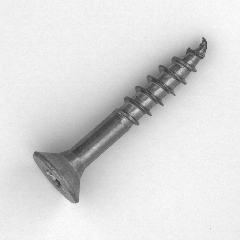

In [12]:
max_instances = 3000
train_imgs_scaled = train_imgs.astype('float32')
train_imgs_scaled /= 255
valid_imgs_scaled = valid_imgs.astype('float32')
valid_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs_scaled[0])

In [13]:
batch_size = 32
num_classes = 2
epochs = 15
input_shape = (240, 240, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
le = LabelEncoder()
le.fit(valid_labels)
valid_labels_enc = le.transform(valid_labels)

print(train_labels[2:10], train_labels_enc[2:10])
print(valid_labels[2:10], valid_labels_enc[2:10])

['not-good' 'good' 'good' 'not-good' 'not-good' 'not-good' 'good' 'good'] [1 0 0 1 1 1 0 0]
['not-good' 'good' 'good' 'not-good' 'not-good' 'not-good' 'good' 'good'] [1 0 0 1 1 1 0 0]


In [14]:
from keras.applications import vgg16, mobilenet_v2
from keras.models import Model
import keras

mobileNet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = mobileNet.layers[-1].output
output = keras.layers.Flatten()(output)
mobileNet_model = Model(mobileNet.input, output)
mobileNet_model.trainable = True

set_trainable = False
for layer in mobileNet_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in mobileNet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

C:\Users\fatim\Anaconda3\envs\deeplearningdev\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
C:\Users\fatim\Anaconda3\envs\deeplearningdev\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000017E11970240>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x0000017E112FE780>,Conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x0000017E79A89E10>,Conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x0000017E11CBF908>,bn_Conv1,False
4,<keras.layers.advanced_activations.ReLU object at 0x0000017E11CBFC50>,Conv1_relu,False
...,...,...,...
151,<keras.layers.normalization.BatchNormalization object at 0x0000017EB856A6A0>,block_16_project_BN,False
152,<keras.layers.convolutional.Conv2D object at 0x0000017EB856ACF8>,Conv_1,False
153,<keras.layers.normalization.BatchNormalization object at 0x0000017EB85FCBE0>,Conv_1_bn,False
154,<keras.layers.advanced_activations.ReLU object at 0x0000017EB8639BE0>,out_relu,False


In [16]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([512, 250]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [17]:
def train_model(hparams):
  model = Sequential()
  model.add(mobileNet_model)
  model.add(Dense(hparams[HP_NUM_UNITS], activation='relu',kernel_initializer='he_uniform', input_dim=input_shape))
  model.add(Dropout(hparams[HP_DROPOUT]))
  model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(hparams[HP_DROPOUT]))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
                optimizer=hparams[HP_OPTIMIZER],
                metrics=['accuracy'])

  history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(valid_imgs_scaled, valid_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs, verbose=1) 
  imgs, labels = load_dataset('test')
  test_imgs = imgs
  test_labels = labels
  test_labels_enc = le.transform(test_labels)
  test_loss, test_acc = model.evaluate(test_imgs,  test_labels_enc)
  
  return test_acc

In [18]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [19]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 250, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 1040 samples, validate on 268 samples
Epoch 1/15
1040/1040 [==============================] - 164s 157ms/step - loss: 2.4228 - accuracy: 0.6317 - val_loss: 0.6874 - val_accuracy: 0.6269
Epoch 2/15
1040/1040 [==============================] - 206s 198ms/step - loss: 0.5264 - accuracy: 0.7231 - val_loss: 0.6789 - val_accuracy: 0.6306
Epoch 3/15
1040/1040 [==============================] - 174s 168ms/step - loss: 0.4077 - accuracy: 0.8038 - val_loss: 0.6692 - val_accuracy: 0.6306
Epoch 4/15
1040/1040 [==============================] - 185s 178ms/step - loss: 0.3513 - accuracy: 0.8433 - val_loss: 0.6901 - val_accuracy: 0.6306
Epoch 5/15
1040/1040 [==============================] - 186s 179ms/step - loss: 0.3348 - accuracy: 0.8538 - val_loss: 0.6856 - val_accuracy: 0.6119
Epoch 6/15
1040/1040 [==============================] - 175s 168ms/step - loss: 0.2758 - accuracy: 0.8837 - val_loss: 0.5644 - val_

In [ ]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(valid_imgs_scaled, valid_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs, verbose=1) 

Train on 1040 samples, validate on 268 samples
Epoch 1/30
1040/1040 [==============================] - 224s 215ms/step - loss: 2.8044 - accuracy: 0.5808 - val_loss: 0.6878 - val_accuracy: 0.6269
Epoch 2/30
1040/1040 [==============================] - 181s 174ms/step - loss: 0.6698 - accuracy: 0.6365 - val_loss: 0.6905 - val_accuracy: 0.6269
Epoch 3/30
1040/1040 [==============================] - 199s 191ms/step - loss: 0.6207 - accuracy: 0.6288 - val_loss: 0.6736 - val_accuracy: 0.6269
Epoch 4/30
1040/1040 [==============================] - 186s 179ms/step - loss: 0.5892 - accuracy: 0.6442 - val_loss: 0.6506 - val_accuracy: 0.6269
Epoch 5/30
1040/1040 [==============================] - 193s 186ms/step - loss: 0.5332 - accuracy: 0.6644 - val_loss: 0.6464 - val_accuracy: 0.6269
Epoch 6/30
1040/1040 [==============================] - 198s 191ms/step - loss: 0.5013 - accuracy: 0.7135 - val_loss: 0.6460 - val_accuracy: 0.6306
Epoch 7/30
1040/1040 [==============================] - 185s 178m

KeyboardInterrupt: 

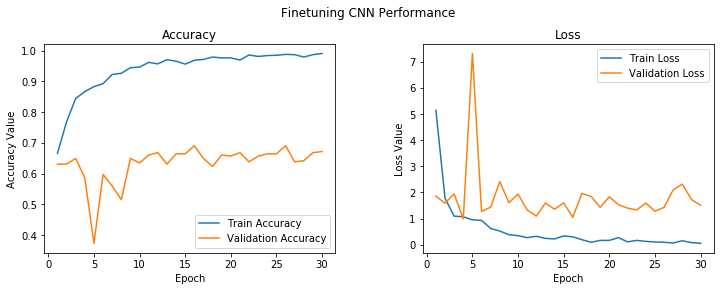

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Finetuning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
imgs, labels = load_dataset('test')
test_imgs = imgs
test_labels = labels
test_labels_enc = le.transform(test_labels)
test_loss, test_acc = model.evaluate(test_imgs,  test_labels_enc, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.3722222149372101
